In [1]:
import siconos.numerics as sn
import scipy.linalg as linalg
import numpy as np
import siconos.kernel as sk
from numpy import eye, empty, float64, zeros, transpose, array
from siconos.kernel import FirstOrderLinearTIDS, FirstOrderType2R, FirstOrderLinearTIR, EqualityConditionNSL, RelayNSL,\
                           ComplementarityConditionNSL, NonSmoothDynamicalSystem, Interaction, \
                           EulerMoreauOSI, MoreauJeanOSI, LCP, TimeDiscretisation, TimeStepping 
import siconos.numerics as sn

In [2]:
class Problem:
    def __init__(self,A,R,b,C,D,e,M,init,T,typeProblem):
        
        self.type = typeProblem
        
        self.init = init
        self.T = T
        # note that t0 = 0 
        
        self.A  = A
        self.R  = R
        self.b  = b
        self.C  = C
        self.D  = D
        self.e  = e
        self.M  = M        

In [3]:
class ConvergenceTest:
    
    def __init__(self,problem,timeSteps):
        self.problem = problem
        self.timeSteps = timeSteps
        
    def simulate(self,p,h):
        time_step = h
        dyn = FirstOrderLinearTIDS(p.init, p.A)
        dyn.setbPtr(p.b)
        dyn.setMPtr(p.M)

        switch = NonSmoothDynamicalSystem(0,p.T)
        switch.insertDynamicalSystem(dyn)
        
        
        rel_python = sk.FirstOrderLinearTIR(p.C, p.R)
        rel_python.setDPtr(p.D)
        rel_python.setePtr(p.e)

        # Declaration that right side is an LCP
        nslaw = ComplementarityConditionNSL(np.size(p.e))    
        # Link between left hand side et right hand side of the LCP
        # 0=< C1*x + D1*λ + e1 _|_ λ>= 0
        interaction = Interaction(nslaw, rel_python)
        switch.link(interaction, dyn)
        
        # Discretization and non-smooth problem formulation (LCP)
        θ = 1.
        γ = 1.
        #osi = EulerMoreauOSI(θ)  # One Step time Integrator for First Order Dynamical Systems.
        # Simple theta method (~backward euler)
        osi = EulerMoreauOSI(θ,γ)  # One Step time Integrator for First Order Dynamical Systems.


        osnspb = sk.LCP(sn.SICONOS_LCP_ENUM)    
        osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_ENUM_MULTIPLE_SOLUTIONS] = 1
        osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_ENUM_USE_DGELS] = 0; 
        osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_SKIP_TRIVIAL] = sn.SICONOS_LCP_SKIP_TRIVIAL_NO       
        # osnspb.setNumericsVerboseMode(True)

        # Simulation and time discretisation
        td = TimeDiscretisation(0, time_step)
        simu = TimeStepping(switch, td, osi, osnspb)

        ##########################################################################
        ## !!! ALWAYS DECLARE COMPUTE RESIDUY and R for NonLinear Relations !!!!
        ##         OTHERWISE NEWTOWN ALG DO NOT USE JACOBIANS 
        #########################################################################
        # simu.setComputeResiduY(True)
        # simu.setComputeResiduR(True)
        # simu.setNewtonMaxIteration(100) #100 more funcky
        # simu.setNewtonTolerance(1e-10)
        ##########################################################################
        
        ############## EXAMPLE SPECIFIC ###################
        ##### Simulation run
        x = dyn.x() # tracking state variables form ODE
        λ = interaction.lambda_(0) # tracking λ variables form LCP
        k = 0

        ##### Numpy array used to save data at each time step, for post-processing
        N = int((T - 0) / simu.timeStep()) + 1
        data_plot = zeros((N, 6))

        ###### Initial state
        data_plot[k, 0] = 0
        data_plot[k, 1] = x[0] # x1
        data_plot[k, 2] = x[1] # x2
        data_plot[k, 3] = x[2] # z
        data_plot[k, 4] = λ[0] # 1-|x1|
        data_plot[k, 5] = λ[1] # 1-sgn(x1)
        k += 1

        xk   = np.copy(p.init)
        xsol = np.copy(p.init)
        lsol = np.array([])
        diff = np.copy(p.init)
        norm = float("inf")
        nb_modes = 8
        norm_diff = 0   
        while simu.hasNextEvent():
#             print('## new step', k)
            for i in range(nb_modes):
               osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_ENUM_SEED] = i
               simu.computeOneStep() # Build and solve the LCP    
               diff = x-xk;
               norm_diff = np.linalg.norm(diff);
#                print('norm : ', norm_diff)
               if norm_diff<norm:
                    xsol = np.copy(x)
                    lsol = np.copy(λ)  
                    norm = norm_diff
#                     print('chose mode : ', i)
#                     print('xsol = ', xsol)   
        #     osnspb.display()
#             print('xsol = ', xsol)
            x[:] = xsol
            λ[:] = lsol

            
            data_plot[k, 0] = simu.nextTime()
            data_plot[k, 1] = x[0] # x1
            data_plot[k, 2] = x[1] # x2
            data_plot[k, 3] = x[2] # z
            data_plot[k, 4] = λ[0] # |x1|
            data_plot[k, 5] = λ[1] # sgn(x1)
            
            xk = np.copy(xsol);
            norm = float("inf");
            
            k += 1 
            #rel_python.display()
            simu.nextStep() # Save current state and prepare next step       
        return data_plot
        
    def run(self):
        errors = np.zeros(np.size(self.timeSteps))   
        i = 0
        for h in self.timeSteps:
           currResults = self.simulate(self.problem,h)
           x1f = currResults[-1,1]
           x2f = currResults[-1,2]   
           xf = np.array([x1f,x2f])  
           if self.problem.type == 'sliding-crossing':                
               # ref uniq sol case with x0 = (-4,5), T = 10
               xf_ref = np.array([6.5*2./3.,6.5*2./3. + 1 ])            
           elif self.problem.type == 'sliding-repulsive':                    
               # ref non-uniq euler case with x0 = (0,0), T= 10
               xf_ref = np.array([8/3.,1.+8/3.])      
           elif self.problem.type == 'non-null-A': 
               # ref linear dyn, x0 = 0,0, B=(-1,0.5), T =10
               xf_ref = np.array([1.8867421308653363, 2.8867421308653363])
           else:
               print("no reference solutions") 
               continue     
            
           diff = xf_ref-xf
           currError = np.linalg.norm(diff) 
           errors[i] = currError
           print(errors[i])
           i=i+1 
            
        return errors
            

In [12]:
timeSteps = np.logspace(-4.4,0.0,100,endpoint=True, base=10.0)
print(timeSteps)

[3.98107171e-05 4.41005945e-05 4.88527357e-05 5.41169527e-05
 5.99484250e-05 6.64082785e-05 7.35642254e-05 8.14912747e-05
 9.02725178e-05 1.00000000e-04 1.10775685e-04 1.22712524e-04
 1.35935639e-04 1.50583635e-04 1.66810054e-04 1.84784980e-04
 2.04696827e-04 2.26754313e-04 2.51188643e-04 2.78255940e-04
 3.08239924e-04 3.41454887e-04 3.78248991e-04 4.19007911e-04
 4.64158883e-04 5.14175183e-04 5.69581081e-04 6.30957344e-04
 6.98947321e-04 7.74263683e-04 8.57695899e-04 9.50118507e-04
 1.05250029e-03 1.16591440e-03 1.29154967e-03 1.43072299e-03
 1.58489319e-03 1.75567629e-03 1.94486244e-03 2.15443469e-03
 2.38658979e-03 2.64376119e-03 2.92864456e-03 3.24422608e-03
 3.59381366e-03 3.98107171e-03 4.41005945e-03 4.88527357e-03
 5.41169527e-03 5.99484250e-03 6.64082785e-03 7.35642254e-03
 8.14912747e-03 9.02725178e-03 1.00000000e-02 1.10775685e-02
 1.22712524e-02 1.35935639e-02 1.50583635e-02 1.66810054e-02
 1.84784980e-02 2.04696827e-02 2.26754313e-02 2.51188643e-02
 2.78255940e-02 3.082399

In [13]:
init  = [0,0,0]
T = 10

B = [-1,0.5] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'sliding-repulsive'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
error_sliding_repulsive = test.run()

1.2070007559149524e-05
6.498439061271805e-06
1.9049485882391237e-05
2.4994189343869832e-05
1.518131178886408e-06
1.9892163981416863e-05
2.2162610522521053e-05
2.0129085105877074e-05
2.9152249424028938e-05
3.6369621712950967e-12
2.70393269514337e-05
1.589006798681935e-05
1.444673316954121e-05
1.9769997189246463e-05
3.342238462191384e-05
8.298429301679704e-05
7.099284661270274e-05
6.35523597200588e-05
8.490757418545841e-05
1.7922962944141206e-05
3.789452131109608e-05
7.17327264344237e-05
0.00010909925920454027
0.00017734900000396082
7.590407862969708e-05
0.00015134231095565028
0.00020484443569078622
0.00027718806492770784
7.574638847869197e-05
0.00018127303322287941
5.822709829215934e-05
1.2777310441842816e-06
9.182468687996555e-05
0.0005270752645856188
0.000387727132707135
0.0003191543075155942
0.0004284354156313305
0.0006710543237532047
0.0006892883613467395
0.000598025454381896
8.899790340234616e-05
0.0006105610124644917
0.0007577621994676116
0.0006105744458489889
0.000947705659560195

In [14]:
init  = [-5,4,0]
T = 10


B = [-0.5,1] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'sliding-crossing'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
error_sliding_crossing = test.run()

2.4139964582675138e-05
1.2996886157648777e-05
3.809895252047322e-05
4.9988360233500944e-05
3.036250009309647e-06
3.9784354947070756e-05
4.4325225053174135e-05
4.0258148320897054e-05
5.8304515128032565e-05
5.162464004152253e-13
5.4078655554604666e-05
3.178014054826008e-05
2.88934600097257e-05
3.953999676252131e-05
6.684477802504078e-05
0.00016596858708744014
0.00014198568983400577
0.00012710471570329752
0.00016981514508377125
3.584592946055678e-05
7.57890426824837e-05
0.00014346545177480697
0.00021819851903711753
0.00035469799859483845
0.00015180815646304328
0.0003026846194581881
0.0004096888718789777
0.0005543761267554251
0.00015149277597387801
0.00036254606652614754
0.00011645419685437458
2.5554617869108107e-06
0.00018364937373983392
0.0010541505298746392
0.0007754542661063666
0.0006383086146154279
0.0008568708309134725
0.0013421086477274785
0.001378576722423423
0.0011960509085866856
0.0001779958064102851
0.0012211220252706355
0.0015155243991675968
0.001221148891478165
0.0018954113193

In [15]:
init  = [0,0,0]
T = 10


B = [-1,0.5] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,1] = 1        # Linear dynamic of x
A[1,0] = -1
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'non-null-A'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
error_non_null_A = test.run()

3.6818038459563323e-06
3.3002096488980786e-06
4.99804956777436e-06
5.977437091965428e-06
3.6576063121751558e-06
6.114237679839207e-06
6.7874908877692214e-06
7.018079268663545e-06
8.550656689114753e-06
5.814439801257578e-06
9.503453435948721e-06
8.934759305765349e-06
9.54011731748187e-06
1.0994748227443689e-05
1.348456493805475e-05
2.014336969401952e-05
1.994285067946841e-05
2.0382753838220595e-05
2.422244339412301e-05
1.8209004426872265e-05
2.221431251787783e-05
2.7978758225607553e-05
3.435076862835967e-05
4.4451709376495775e-05
3.5585970117764474e-05
4.703935679582723e-05
5.632263657090755e-05
6.808684810890035e-05
4.921829141710917e-05
6.555255997435315e-05
5.6463184832882165e-05
5.538828251539397e-05
7.159781844746129e-05
0.0001275115030223856
0.00011901878236440585
0.00011935025761763813
0.00014069897004739267
0.00017812707029052748
0.00019120110816436028
0.00019302979770494634
0.00014885498191303357
0.00022288962663683833
0.00025613857717628663
0.00025780074285248404
0.00031641189

<IPython.core.display.Javascript object>


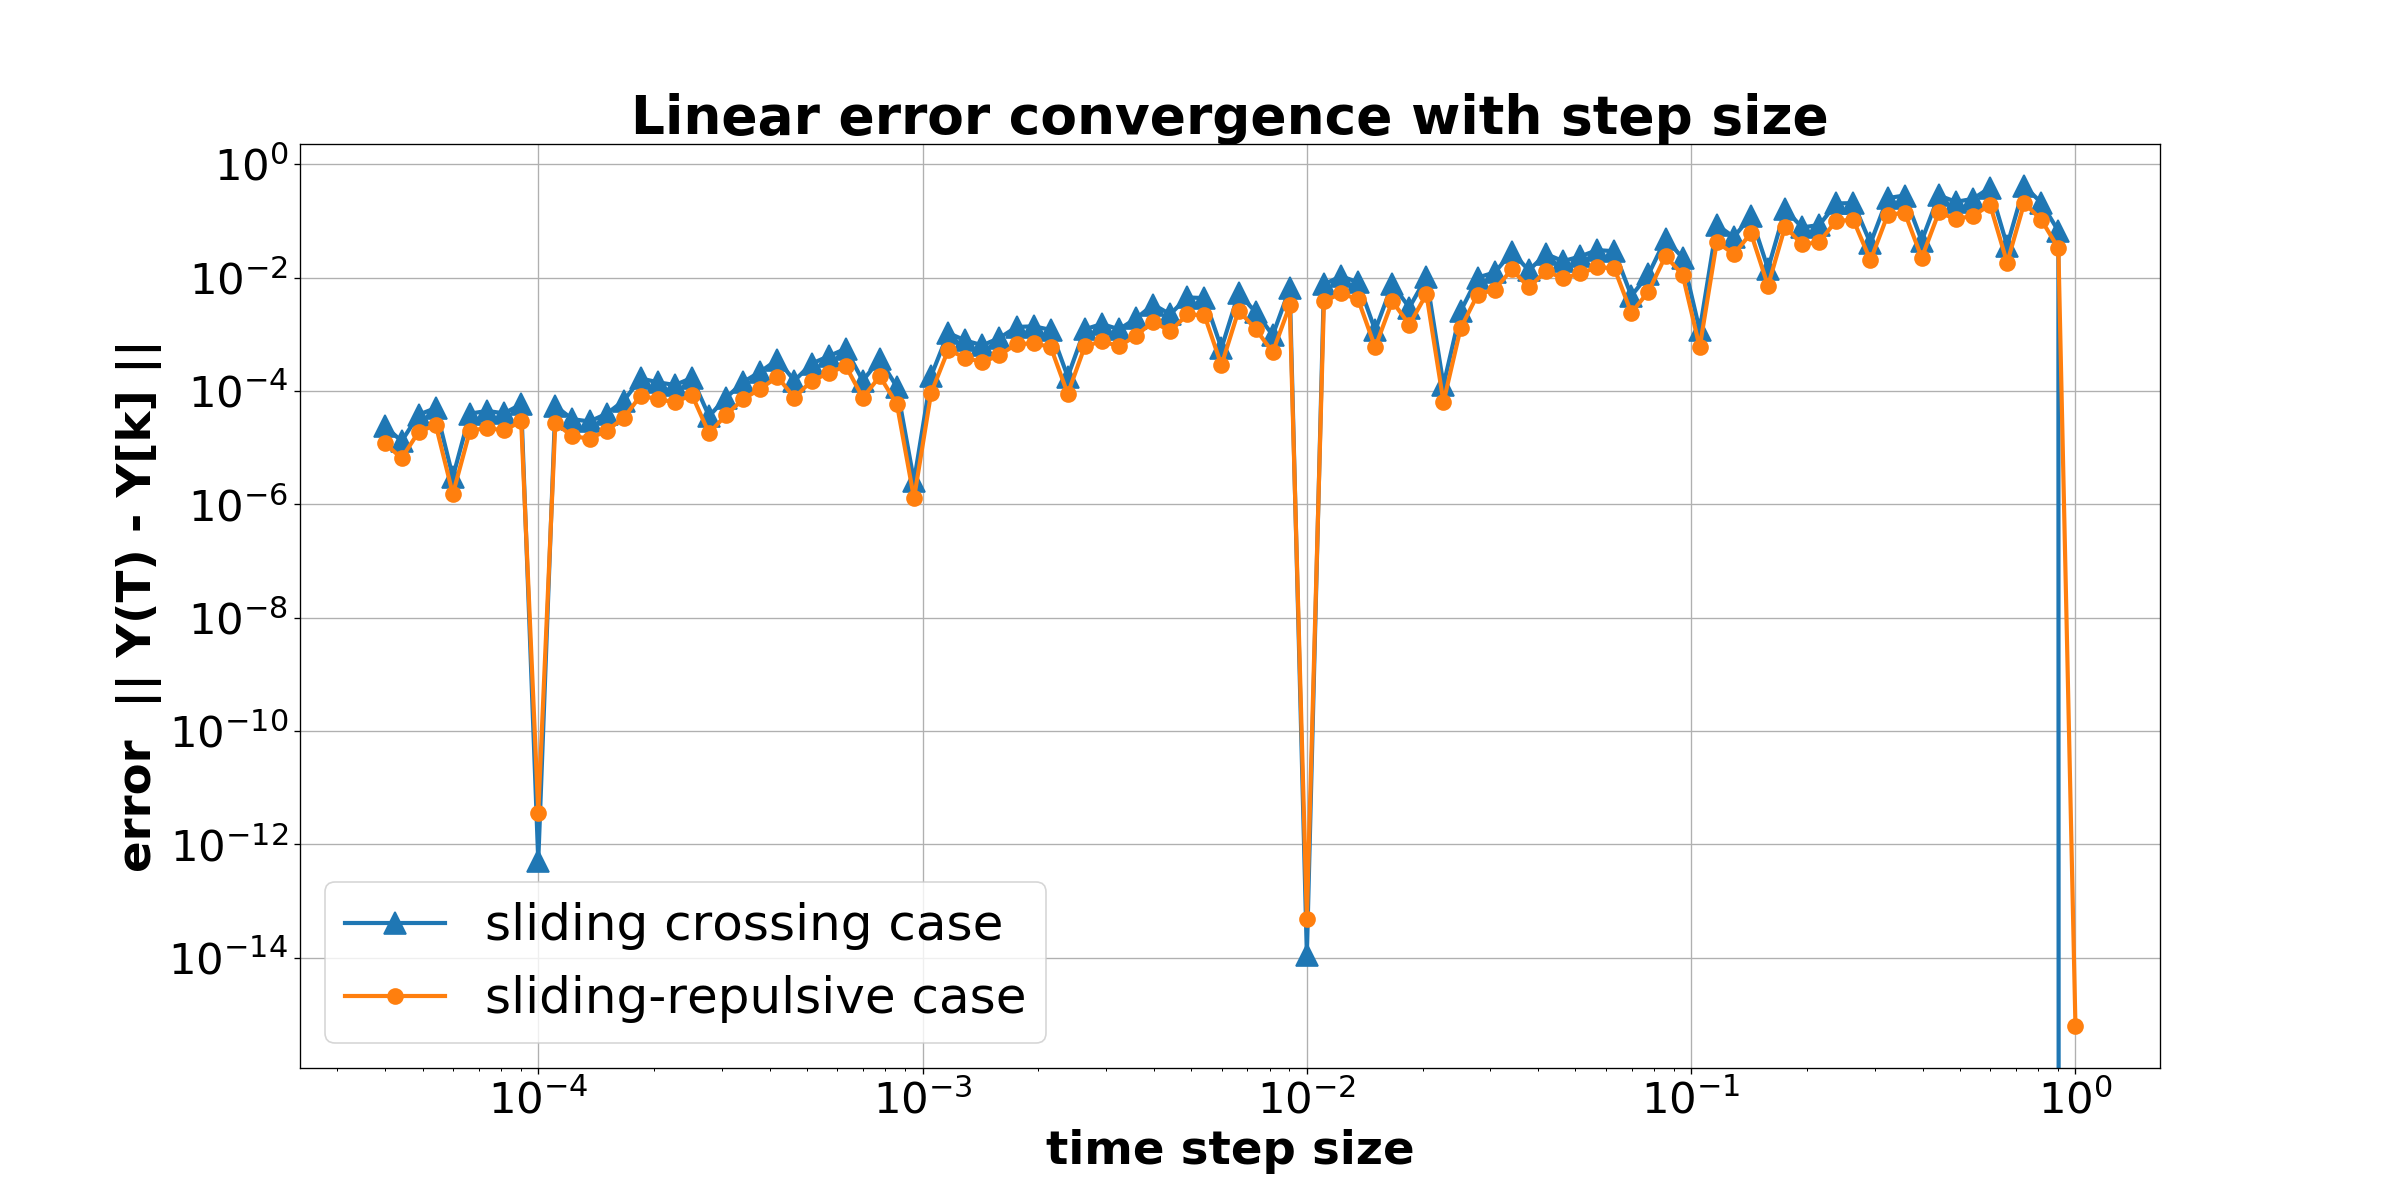

In [18]:
import ipympl
import matplotlib.pyplot as plt
%matplotlib notebook

hstep_size = timeSteps
lcp_uniq_err = error_sliding_crossing
lcp_notuniq_err = error_sliding_repulsive
lcp_lin_err = error_non_null_A
plt.figure(figsize=(20,10))
plt.title('Linear error convergence with step size',fontsize=32,fontweight='heavy')
c1 = plt.plot(hstep_size,lcp_uniq_err, linewidth=2.5, marker='^', markersize=13, label='sliding crossing case')
c2 = plt.plot(hstep_size,lcp_notuniq_err, linewidth=2.5, marker='.', markersize=18, label='sliding-repulsive case')
# c3 = plt.plot(hstep_size,lcp_lin_err, linewidth=2.5, marker='x', markersize=15 ,label='non null matrix A')
plt.xlabel('time step size',fontsize=28,fontweight='bold')
plt.ylabel('error  || Y(T) - Y[k] ||',fontsize=28,fontweight='bold')
plt.xscale('log')
plt.yscale('log')
ax = plt.axes()
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
plt.grid()

<IPython.core.display.Javascript object>


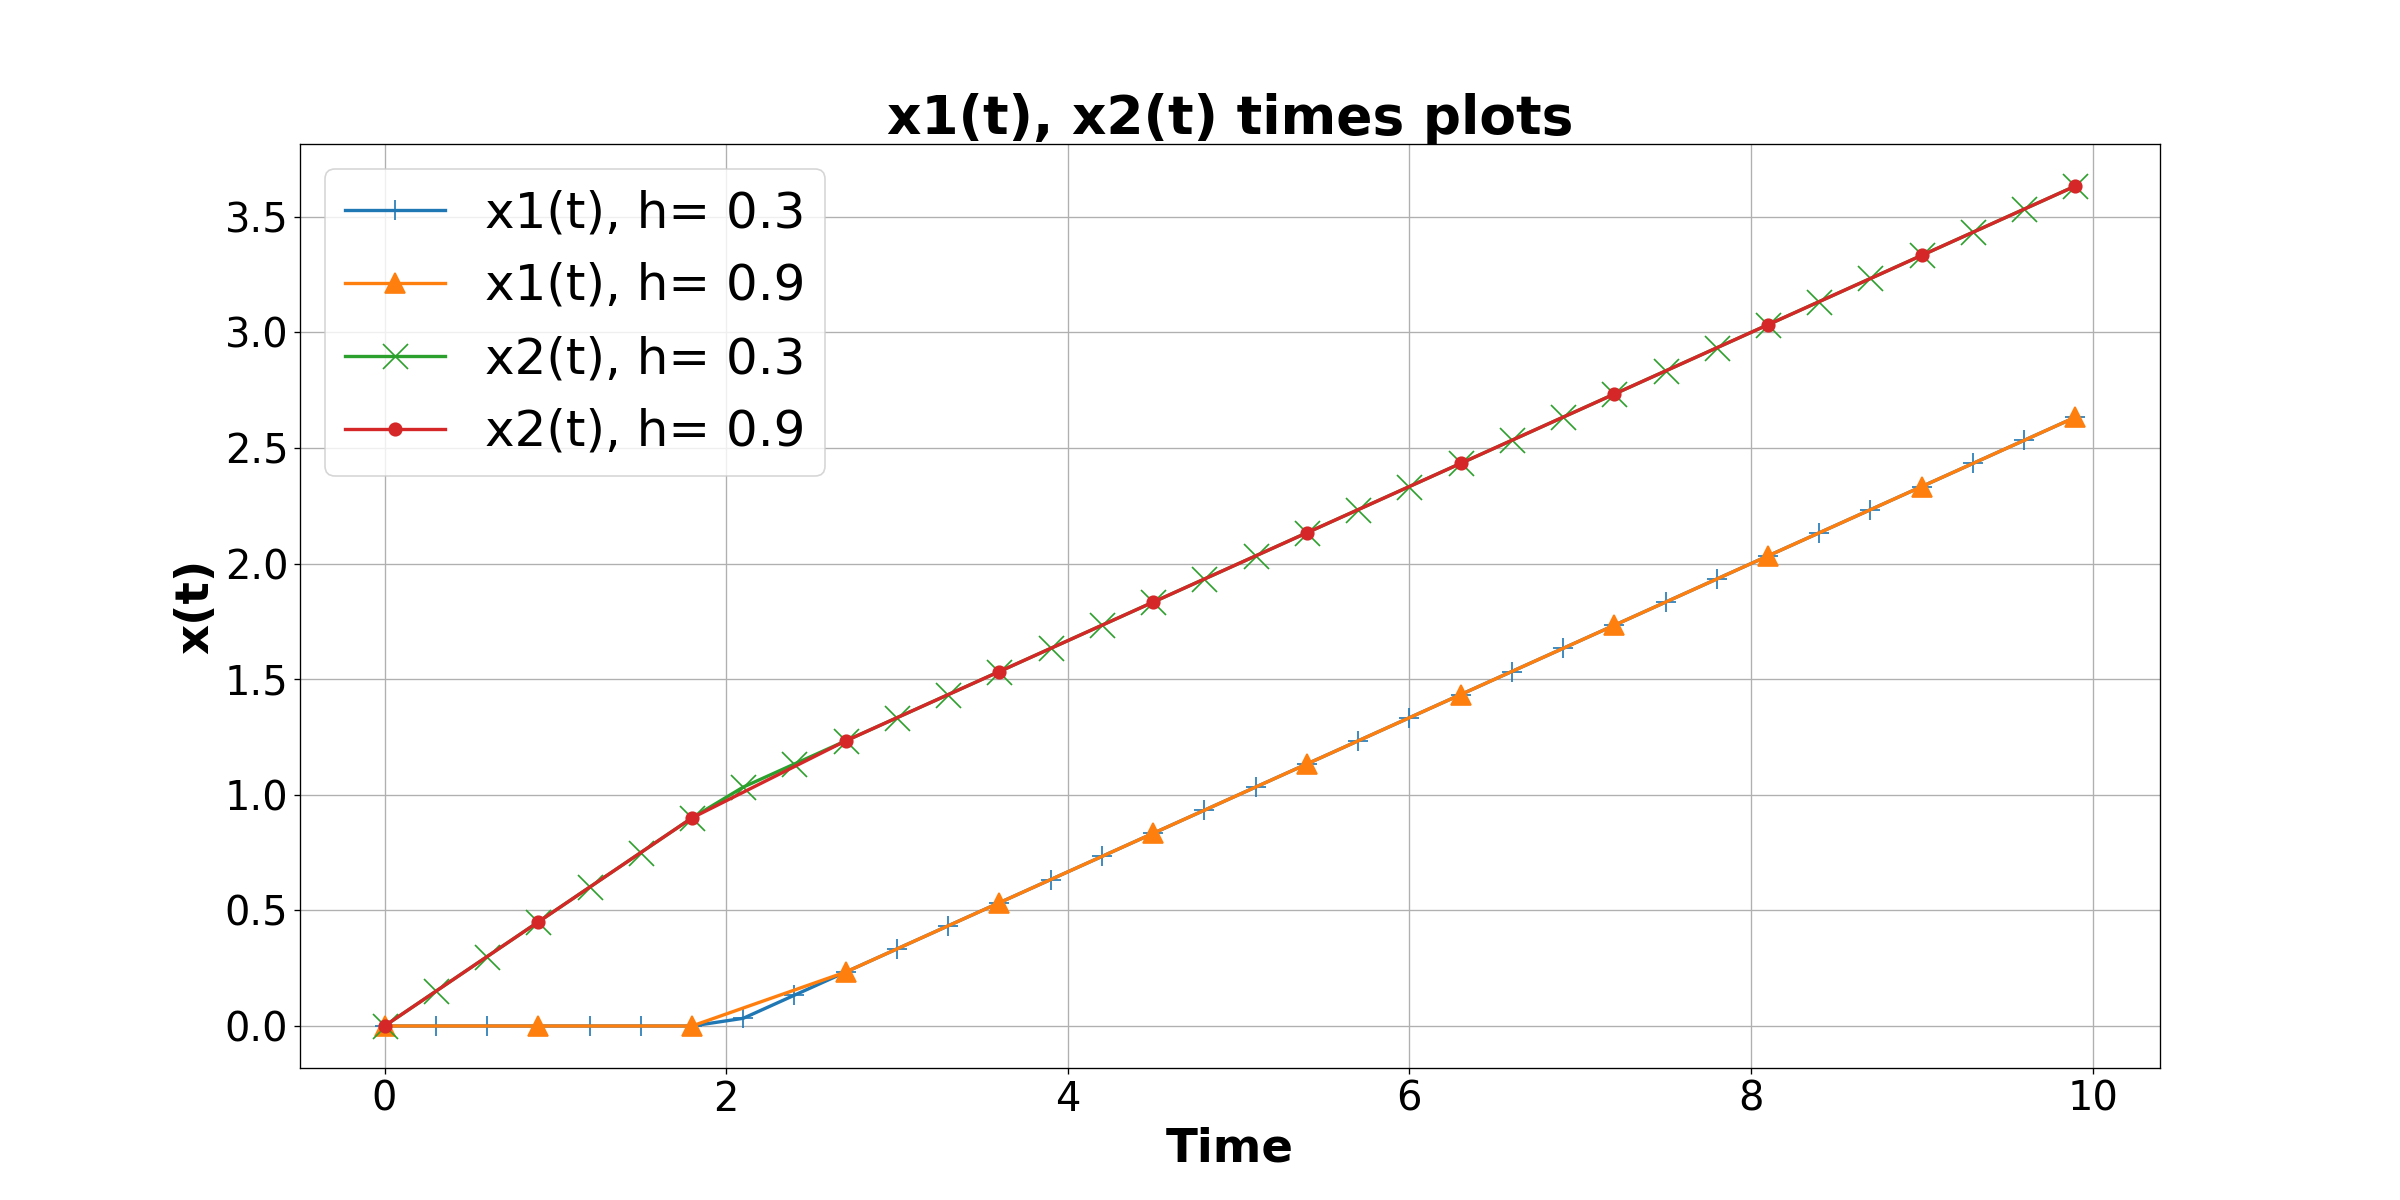

<IPython.core.display.Javascript object>


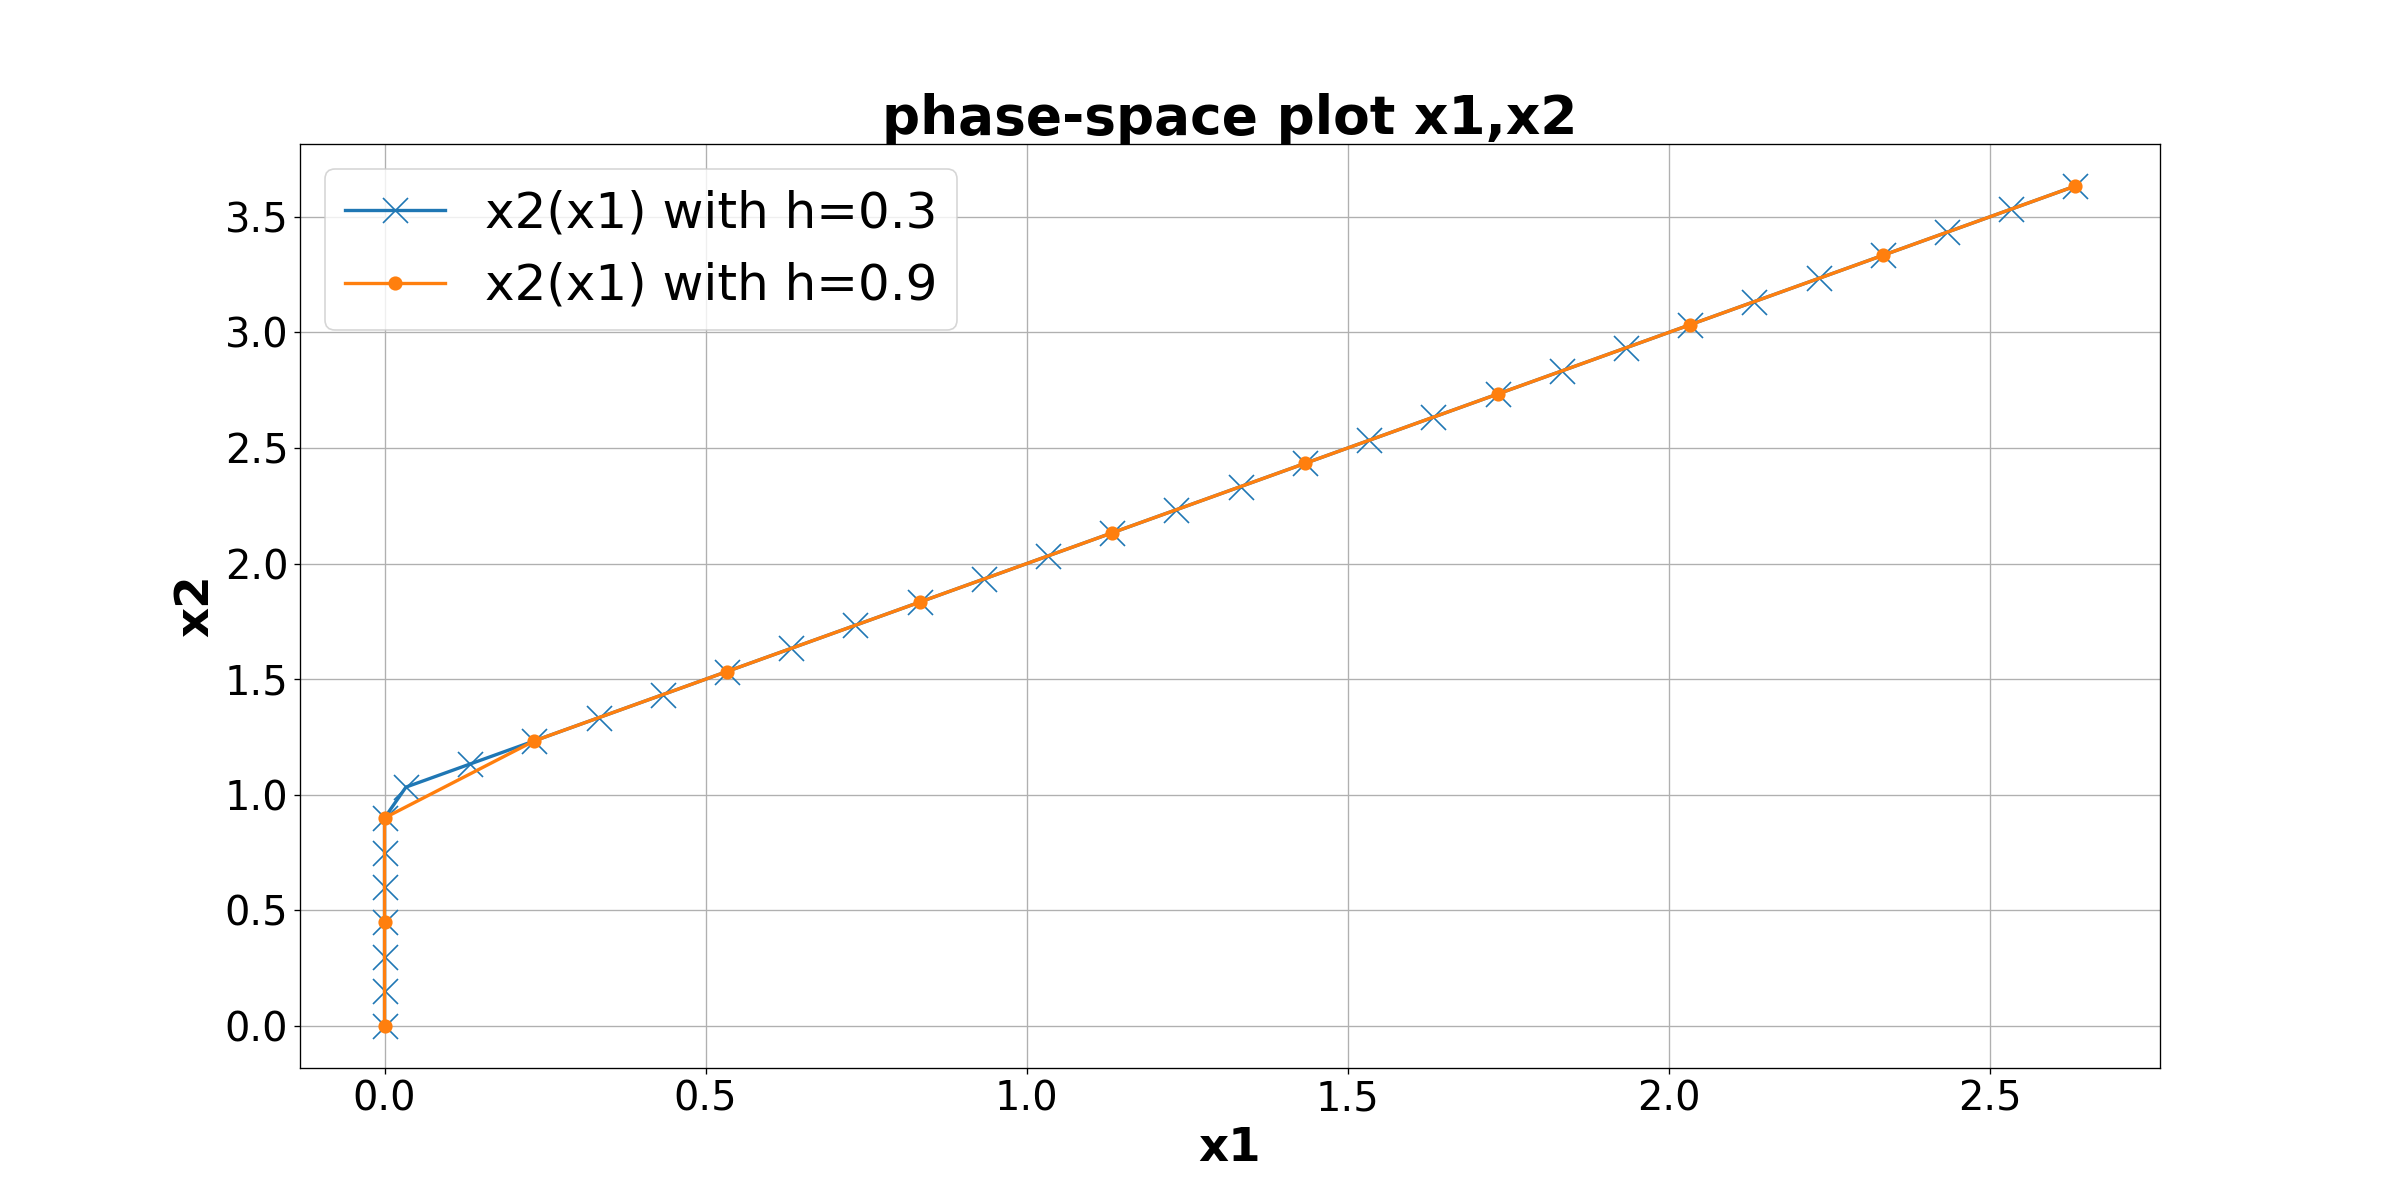

In [25]:
init  = [0,0,0]
T = 10

B = [-1.0,0.5] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'sliding-repulsive'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
results_0_3 = test.simulate(pb,0.3)
results_0_9 = test.simulate(pb,0.9)

plt.figure(figsize=(20,10))
plt.title('x1(t), x2(t) times plots',fontsize=32,fontweight='heavy')
plt.plot(results_0_3[: , 0], results_0_3[: , 1], linewidth=2., marker='+', markersize=12,label='x1(t), h= 0.3')
plt.plot(results_0_9[: , 0], results_0_9[:, 1], linewidth=2., marker='^', markersize=12,label='x1(t), h= 0.9')
plt.plot(results_0_3[:, 0], results_0_3[:, 2], linewidth=2., marker='x', markersize=15,label='x2(t), h= 0.3')
plt.plot(results_0_9[:, 0], results_0_9[:, 2], linewidth=2., marker='.', markersize=15,label='x2(t), h= 0.9')
plt.xlabel('Time',fontsize=28,fontweight='bold')
plt.ylabel('x(t)',fontsize=28,fontweight='bold')
plt.grid()
ax = plt.axes()
ax.tick_params(axis='both', labelsize='24')
plt.legend(fancybox=True, fontsize=30)

plt.figure(figsize=(20,10))
plt.title('phase-space plot x1,x2',fontsize=32,fontweight='heavy')
plt.plot(results_0_3[:, 1], results_0_3[: , 2], linewidth=2., marker='x', markersize=15,label='x2(x1) with h=0.3')
plt.plot(results_0_9[:, 1], results_0_9[:, 2], linewidth=2., marker='.', markersize=15,label='x2(x1) with h=0.9')
plt.xlabel('x1',fontsize=28,fontweight='bold')
plt.ylabel('x2',fontsize=28,fontweight='bold')
plt.grid()
ax = plt.axes()
ax.tick_params(axis='both', labelsize='24')
plt.legend(fancybox=True, fontsize=30)